In [1]:
import numpy as np  
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model

from processing_functions import * 

import os
os.chdir('../') # Go to the parent folder
from support_functions import *
from Autoencoder_Functions import *
os.chdir('MNIST')

Using TensorFlow backend.


## Parameters

In [2]:
anomaly_digit = 2 # Set digit 2 as our anomaly
n_components=30 # 30 components in the encoded matrix
k = 50 # Define the k parameter for the precision at k

## Read Data

In [3]:
data_path = 'data/input_data/'
# Read image matrix (n*m), labels (vector of m), and image size
imgs_train, imgs_test, labels_train, labels_test, height, width = read_process_data(data_path, anomaly_digit)
# The length of one image vector
img_size = height*width 

### Load the Saved Models
#### Autoencoder Model

In [4]:
# Generate and Compile a Deep Autoencoder
# Specify the model config
encoder_layers_size, decoder_layers_size = get_deep_model_config()
# Extract the saved model
autoencoder, encoder = compile_autoencoder(img_size,encoder_layers_size, decoder_layers_size) 
autoencoder = load_model('model_autoencoder.h5') # Load the saved model

### Visualize the Reconstructed Image

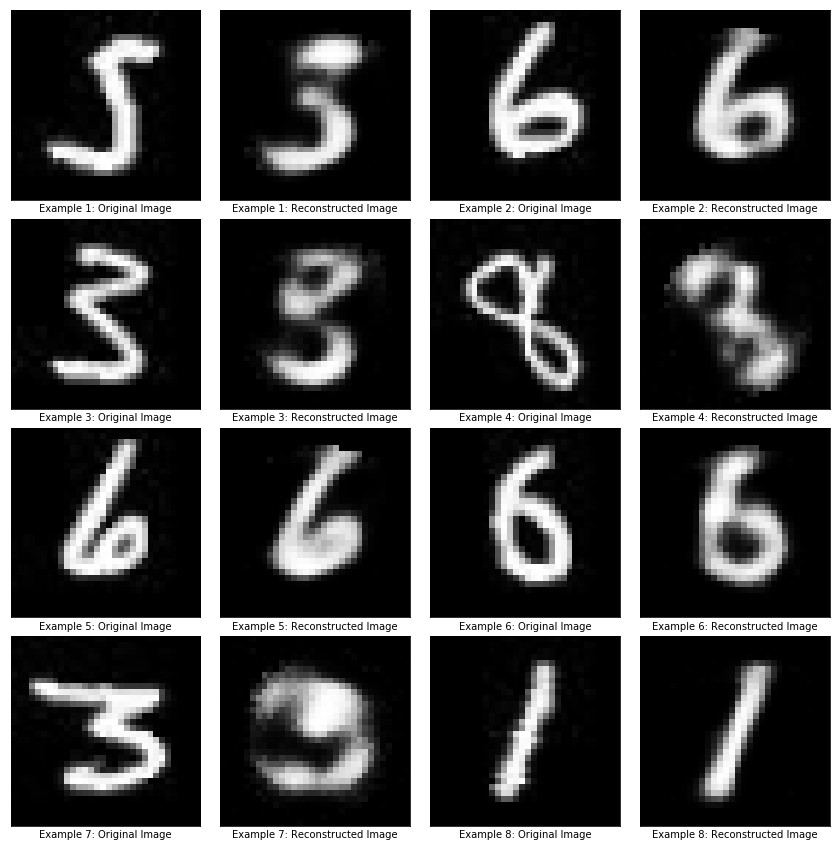

In [5]:
imgs_train_reconstructed = reconstruct_with_autoencoder(autoencoder,imgs_train,visual =True,height = height, width = width)

## Implement the Anomaly Detection¶with Construction Error

In [6]:
# In addition to the training data, we also need to reconstruct the test data
imgs_test_reconstructed = reconstruct_with_autoencoder(autoencoder,imgs_test,visual =False,height = height, width = width)

The higher the reconstruction error, the more likely the point will be an anomaly


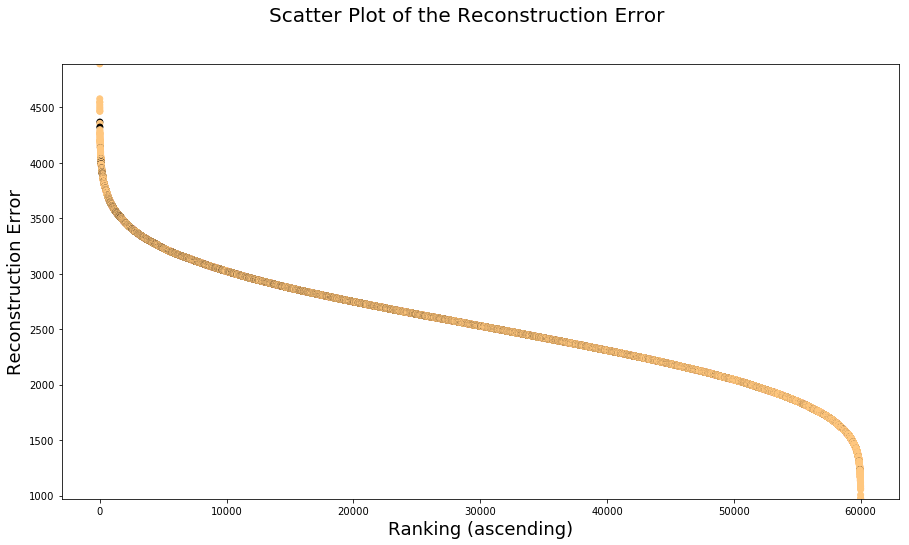

Training Results:
Precision: 12.2%
Recall: 87.7%
F-score: 21.4%
Precision@5958.0: 15.5%

Testing Results:
Precision: 12.3%
Recall: 87.7%
F-score: 21.6%
Precision@1032.0: 16.3%


In [7]:
train_test_with_reconstruction_error(imgs_train, imgs_train_reconstructed, imgs_test, imgs_test_reconstructed, labels_train, labels_test)